# Import

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import  TensorDataset, DataLoader
from torchinfo import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# Data Load

In [3]:
path_fault2_ex = 'C:/Users/baek/Desktop/NURO/data_cycle/abnormal2/external'
path_fault2_in = 'C:/Users/baek/Desktop/NURO/data_cycle/abnormal2/internal'

path_fault1_ex = 'C:/Users/baek/Desktop/NURO/data_cycle/abnormal1/external'
path_fault1_in = 'C:/Users/baek/Desktop/NURO/data_cycle/abnormal1/internal'

path_normal_ex = 'C:/Users/baek/Desktop/NURO/data_cycle/normal/external'
path_normal_in = 'C:/Users/baek/Desktop/NURO/data_cycle/normal/internal'

In [4]:
dat_f1 = [[] for i in range(0,2)]
dat_f2 = [[] for i in range(0,2)]
dat_n = []

In [5]:
for i in range(len(os.listdir(path_fault1_ex))):
    temp =pd.read_csv(path_fault1_ex + '/'+ os.listdir(path_fault1_ex)[i], sep = '\t' )
    dat_f1[0].append(temp)
    
    
for i in range(len(os.listdir(path_fault1_in))):
    temp = pd.read_csv(path_fault1_in + '/'+os.listdir(path_fault1_in)[i], sep = ',' , low_memory=False)
    dat_f1[1].append(temp)

    
for i in range(len(os.listdir(path_fault2_ex))):
    temp =pd.read_csv(path_fault2_ex + '/'+ os.listdir(path_fault2_ex)[i], sep = '\t' )
    dat_f2[0].append(temp)
    
    
for i in range(len(os.listdir(path_fault2_in))):
    temp = pd.read_csv(path_fault2_in + '/'+os.listdir(path_fault2_in)[i], sep = ',' , low_memory=False)
    dat_f2[1].append(temp)
    
    
for i in range(len(os.listdir(path_normal_ex))):
    temp =pd.read_csv(path_normal_ex + '/'+os.listdir(path_normal_ex)[i], sep = '\t' )
    dat_n.append(temp)

In [6]:
data_f1 = []
data_f2 = []
data_n = []

for i in range(len(dat_f1[1])):
    data_n.append(dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(1),:].reset_index().drop(labels = 'index', axis=1))


for i in range(len(dat_f1[1])):
    data_f1.append(dat_f1[1][i].loc[dat_f1[1][i]['CoreSN'] == 'core0'+str(2),:].reset_index().drop(labels = 'index', axis=1))

    
for i in range(len(dat_f2[1])):
    data_f2.append(dat_f2[1][i].loc[dat_f2[1][i]['CoreSN'] == 'core0'+str(2),:].reset_index().drop(labels = 'index', axis=1))


In [7]:
d_n = []
d_f1 = []
d_f2 = []


for i in range(0,5):
    for j in range(len(data_n[i])//511):
        d_n.append(data_n[i].loc[511*j:511*(j+1),'ActualTorque'])

for i in range(0,5):
    for j in range(len(data_f1[i])//511):
        d_f1.append(data_f1[i].loc[511*j:511*(j+1),'ActualTorque'])
        
for i in range(0,5):
    for j in range(len(data_f2[i])//511):
        d_f2.append(data_f2[i].loc[511*j:511*(j+1),'ActualTorque'])


In [8]:
label_n = [0 for i in range(len(d_n))]
label_f1 = [1 for i in range(len(d_f1))]
label_f2 = [2 for i in range(len(d_f2))]


d_n.extend(d_f1)
label_n.extend(label_f1)

d_n.extend(d_f2)
label_n.extend(label_f2)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(d_n,label_n,test_size=0.2, random_state=42)

for i in range(len(X_train)):
    X_train[i] = np.array(X_train[i])
    
for i in range(len(X_valid)):
    X_valid[i] = np.array(X_valid[i])
    
X_valid = np.array(X_valid)
X_train = np.array(X_train)
y_valid = np.array(y_valid)
y_train = np.array(y_train)

X_valid = X_valid.reshape(len(X_valid),1,512)
X_train = X_train.reshape(len(X_train),1,512)


In [11]:
X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)

X_train = X_train.view([-1,1, 512])
X_valid = X_valid.view([-1,1, 512])

y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [12]:
Train = TensorDataset(X_train,y_train)
Valid = TensorDataset(X_valid, y_valid)



Train_loader = DataLoader(Train, batch_size=32, shuffle=True)
Valid_loader = DataLoader(Valid, batch_size=32, shuffle=True)

# Model

In [270]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1,32,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(32,64,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(64,64,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(64,128,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(128,128,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv1d(128,256,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(256,256,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
    
        self.fc1 = nn.Linear(8192,2000, bias = True)
        self.fc2 = nn.Linear(2000,500, bias = True)
        self.fc3 = nn.Linear(500,100, bias = True)
        self.fc4 = nn.Linear(100,3, bias = True)
        torch.nn.init.xavier_uniform_(self.fc4.weight)
#Convolution - Batch Normalization - Activation - Dropout - Pooling
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = out.view(out.size(0),-1)
        #print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        out = self.fc4(out)
        return out


In [189]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1,32,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(32,64,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(64,64,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(64,128,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(128,128,kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv1d(128,256,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(256,256,kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool1d(2)
        )
    
    
        self.fc1 = nn.Linear(8192,4000, bias = True)
        self.fc2 = nn.Linear(1000,100, bias = True)
        self.fc3 = nn.Linear(100,3, bias = True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
#Convolution - Batch Normalization - Activation - Dropout - Pooling
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = out.view(out.size(0),-1)
        #print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [271]:
# instantiate CNN model
model = CNN().to(device)

# Train & Valid

In [272]:
# parameters
learning_rate = 0.001
training_epochs = 160
batch_size = 32

In [273]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [274]:
# train my model
accuracy_list = []
accuracy_val_list = []

total_train_batch = len(Train_loader)
total_valid_batch = len(Valid_loader)

print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    avg_acc = 0
    for X, Y in Train_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_train_batch
        pred = hypothesis.argmax(dim = 1)
        avg_acc += torch.eq(pred, Y).sum().float().item()
    avg_acc =avg_acc/ 898
    with torch.no_grad():
        avg_val_loss = 0
        val_loss = 0
        avg_val_acc = 0
        for X_val, Y_val in Valid_loader:
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)
            
            y_val_pred = model(X_val)
            val_step_loss = criterion(y_val_pred,Y_val)
            avg_val_loss += val_step_loss / total_valid_batch
            pred_val = y_val_pred.argmax(dim = 1)
            avg_val_acc += torch.eq(pred_val, Y_val).sum().float().item()
        avg_val_acc = avg_val_acc/ 225
    print('[Epoch: {:>4}] train_cost = {:>.9}, valid_cost = {:>.9}'.format(epoch + 1, avg_cost,avg_val_loss))
    print('[Epoch: {:>4}] train_acc = {:>.9}, valid_acc = {:>.9}'.format(epoch + 1, avg_acc, avg_val_acc))
    accuracy_list.append(avg_acc)
    accuracy_val_list.append(avg_val_acc)



print('Learning Finished!')


Learning started. It takes sometime.
[Epoch:    1] train_cost = 9.09662247, valid_cost = 1.52626824
[Epoch:    1] train_acc = 0.461024499, valid_acc = 0.533333333
[Epoch:    2] train_cost = 1.06143451, valid_cost = 0.942629814
[Epoch:    2] train_acc = 0.569042316, valid_acc = 0.546666667
[Epoch:    3] train_cost = 0.742645562, valid_cost = 0.732556462
[Epoch:    3] train_acc = 0.59688196, valid_acc = 0.635555556
[Epoch:    4] train_cost = 0.642197847, valid_cost = 0.694279134
[Epoch:    4] train_acc = 0.672605791, valid_acc = 0.662222222
[Epoch:    5] train_cost = 0.629816353, valid_cost = 0.78524226
[Epoch:    5] train_acc = 0.654788419, valid_acc = 0.622222222
[Epoch:    6] train_cost = 0.698996782, valid_cost = 0.793046117
[Epoch:    6] train_acc = 0.631403118, valid_acc = 0.537777778
[Epoch:    7] train_cost = 0.590044022, valid_cost = 0.788190663
[Epoch:    7] train_acc = 0.706013363, valid_acc = 0.613333333
[Epoch:    8] train_cost = 0.636668921, valid_cost = 0.545665264
[Epoch:

[Epoch:   65] train_cost = 0.0250816792, valid_cost = 0.0728565976
[Epoch:   65] train_acc = 0.979955457, valid_acc = 0.964444444
[Epoch:   66] train_cost = 0.00905270875, valid_cost = 0.0821126699
[Epoch:   66] train_acc = 0.982182628, valid_acc = 0.964444444
[Epoch:   67] train_cost = 0.00841134507, valid_cost = 0.132368341
[Epoch:   67] train_acc = 0.982182628, valid_acc = 0.968888889
[Epoch:   68] train_cost = 0.0157775786, valid_cost = 0.0187553074
[Epoch:   68] train_acc = 0.979955457, valid_acc = 0.977777778
[Epoch:   69] train_cost = 0.0205625705, valid_cost = 0.164573282
[Epoch:   69] train_acc = 0.979955457, valid_acc = 0.96
[Epoch:   70] train_cost = 0.0311280172, valid_cost = 0.157506615
[Epoch:   70] train_acc = 0.975501114, valid_acc = 0.946666667
[Epoch:   71] train_cost = 0.0135107962, valid_cost = 0.218499824
[Epoch:   71] train_acc = 0.981069042, valid_acc = 0.942222222
[Epoch:   72] train_cost = 0.0477608629, valid_cost = 0.0444072634
[Epoch:   72] train_acc = 0.9743

[Epoch:  129] train_cost = 0.00650963653, valid_cost = 0.049311094
[Epoch:  129] train_acc = 0.9844098, valid_acc = 0.968888889
[Epoch:  130] train_cost = 0.00820565782, valid_cost = 0.157471389
[Epoch:  130] train_acc = 0.982182628, valid_acc = 0.951111111
[Epoch:  131] train_cost = 0.0140631516, valid_cost = 0.0618069507
[Epoch:  131] train_acc = 0.981069042, valid_acc = 0.96
[Epoch:  132] train_cost = 0.0231379382, valid_cost = 0.141131982
[Epoch:  132] train_acc = 0.978841871, valid_acc = 0.951111111
[Epoch:  133] train_cost = 0.00935957488, valid_cost = 0.14199096
[Epoch:  133] train_acc = 0.9844098, valid_acc = 0.96
[Epoch:  134] train_cost = 0.0131108155, valid_cost = 0.164541394
[Epoch:  134] train_acc = 0.982182628, valid_acc = 0.96
[Epoch:  135] train_cost = 0.0175721794, valid_cost = 0.134643912
[Epoch:  135] train_acc = 0.983296214, valid_acc = 0.955555556
[Epoch:  136] train_cost = 0.0194945037, valid_cost = 0.0692949295
[Epoch:  136] train_acc = 0.981069042, valid_acc = 0

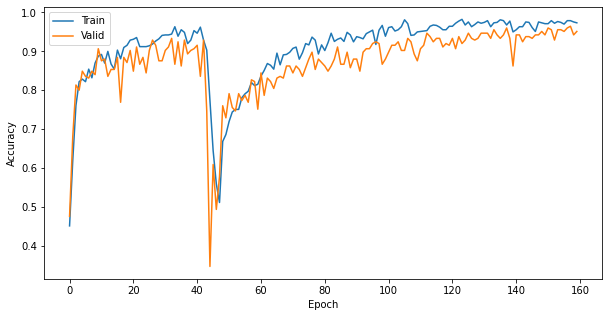

In [219]:
plt.figure(figsize=(10,5))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy_list, label='Train')
plt.plot(accuracy_val_list, label='Valid')

plt.legend()

plt.show()

# Test 

In [220]:
d_n_test = []
d_f1_test = []
d_f2_test = []


for i in range(5,9):
    for j in range(len(data_n[i])//511):
        d_n_test.append(data_n[i].loc[511*j:511*(j+1),'ActualTorque'])

for i in range(5,9):
    for j in range(len(data_f1[i])//511):
        d_f1_test.append(data_f1[i].loc[511*j:511*(j+1),'ActualTorque'])
        
for i in range(5,9):
    for j in range(len(data_f2[i])//511):
        d_f2_test.append(data_f2[i].loc[511*j:511*(j+1),'ActualTorque'])


In [221]:
label_n_test = [0 for i in range(len(d_n_test))]
label_f1_test = [1 for i in range(len(d_f1_test))]
label_f2_test = [2 for i in range(len(d_f2_test))]


d_n_test.extend(d_f1_test)
label_n_test.extend(label_f1_test)

d_n_test.extend(d_f2_test)
label_n_test.extend(label_f2_test)

In [222]:
X_test, X_bu, y_test, y_bu = train_test_split(d_n_test,label_n_test,test_size=0.1, random_state=42)

for i in range(len(X_test)):
    X_test[i] = np.array(X_test[i])
    
for i in range(len(X_bu)):
    X_bu[i] = np.array(X_bu[i])
    
X_test = np.array(X_test)
X_bu = np.array(X_bu)
y_bu = np.array(y_bu)
y_test = np.array(y_test)

X_bu = X_bu.reshape(len(X_bu),1,512)
X_test = X_test.reshape(len(X_test),1,512)


In [223]:
X_test = torch.FloatTensor(X_test)
X_test = X_test.view([-1,1, 512])

y_test = torch.LongTensor(y_test)

In [225]:
Test = TensorDataset(X_test, y_test)
Test_loader = DataLoader(Test, batch_size=32, shuffle=True)

In [320]:
total_test_batch = len(Test_loader)
mean_avg = 0
for i in range(50):
    with torch.no_grad():
        avg_test_loss = 0
        test_loss = 0
        avg_test_acc = 0
        for X_test, Y_test in Test_loader:
            X_test = X_test.to(device)
            Y_test = Y_test.to(device)

            y_test_pred = model(X_test)
            test_step_loss = criterion(y_test_pred,Y_test)
            avg_test_loss += test_step_loss / total_test_batch
            pred_test = y_test_pred.argmax(dim = 1)
            avg_test_acc += torch.eq(pred_test, Y_test).sum().float().item()
        avg_test_acc = avg_test_acc/ 913
    mean_avg += avg_test_acc
mean_avg/=50

#print('TEST_cost = {:>.9}'.format(avg_test_loss))
print('TEST_acc = {:>.9}'.format( mean_avg))

TEST_acc = 0.87754655


In [308]:
summary(model,input_size = (batch_size, 1,512))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 256]             --
│    └─Conv1d: 2-1                       [32, 32, 512]             128
│    └─BatchNorm1d: 2-2                  [32, 32, 512]             64
│    └─ReLU: 2-3                         [32, 32, 512]             --
│    └─Dropout: 2-4                      [32, 32, 512]             --
│    └─MaxPool1d: 2-5                    [32, 32, 256]             --
├─Sequential: 1-2                        [32, 64, 128]             --
│    └─Conv1d: 2-6                       [32, 64, 256]             6,208
│    └─ReLU: 2-7                         [32, 64, 256]             --
│    └─Conv1d: 2-8                       [32, 64, 256]             12,352
│    └─BatchNorm1d: 2-9                  [32, 64, 256]             128
│    └─ReLU: 2-10                        [32, 64, 256]             --
│    └